[*********************100%%**********************]  6 of 6 completed


Optimized Portfolio Weights:
AAPL: 18.30%
AMZN: 0.00%
GOOGL: 0.00%
MCD: 24.81%
MSFT: 0.00%
TSLA: 56.89%
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.4545919963887374
Annualized Volatility: 0.4335788922076957
Allocation:

AAPL: 23.74%
AMZN: 1.12%
GOOGL: 0.52%
MCD: 25.83%
MSFT: 2.08%
TSLA: 46.71%

Minimum Volatility Portfolio Allocation

Annualized Return: 0.14743599688817807
Annualized Volatility: 0.2581917306495484
Allocation:

AAPL: 10.57%
AMZN: 15.36%
GOOGL: 13.24%
MCD: 55.46%
MSFT: 5.21%
TSLA: 0.16%


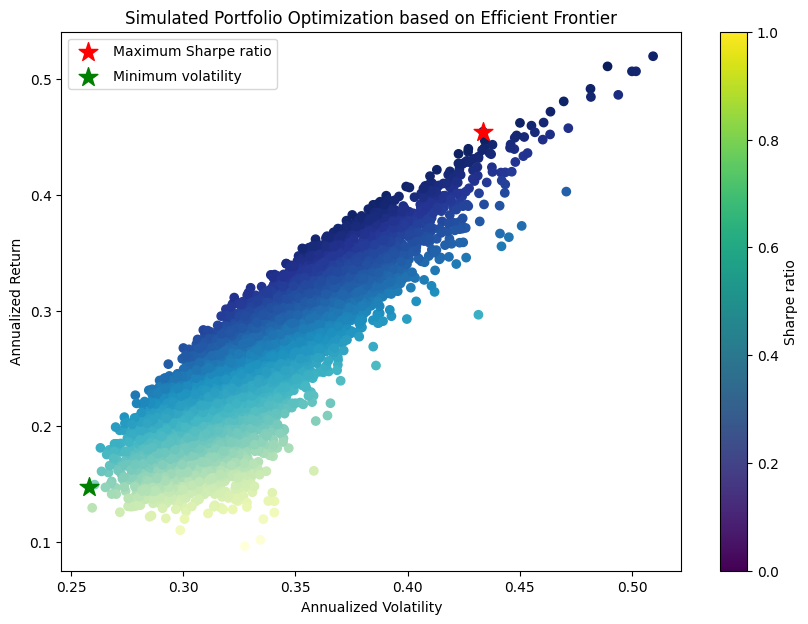

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import yfinance as yf

# List of ticker symbols
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'MCD', 'TSLA']

# Download data
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# Save to CSV
data.to_csv('historical_prices.csv')

# Load historical price data
data = pd.read_csv('historical_prices.csv', index_col='Date', parse_dates=True)

# Calculate daily returns
returns = data.pct_change().dropna()

# Define functions for portfolio metrics
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_return = portfolio_return(weights, mean_returns)
    p_volatility = portfolio_volatility(weights, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

# Optimization function
def optimize_portfolio(mean_returns, cov_matrix, risk_free_rate=0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Generate efficient frontier
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = portfolio_return(weights, mean_returns)
    volatility = portfolio_volatility(weights, cov_matrix)
    return returns, volatility

def generate_efficient_frontier(mean_returns, cov_matrix, num_portfolios=100, risk_free_rate=0):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        p_return, p_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = p_volatility
        results[1,i] = p_return
        results[2,i] = (p_return - risk_free_rate) / p_volatility
    return results, weights_record

# Visualize efficient frontier
def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0):
    results, weights = generate_efficient_frontier(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = weights[max_sharpe_idx]

    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]
    min_vol_allocation = weights[min_vol_idx]

    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", rp)
    print("Annualized Volatility:", sdp)
    print("Allocation:\n")
    for i, col in enumerate(data.columns):
        print(f"{col}: {max_sharpe_allocation[i]:.2%}")

    print("\nMinimum Volatility Portfolio Allocation\n")
    print("Annualized Return:", rp_min)
    print("Annualized Volatility:", sdp_min)
    print("Allocation:\n")
    for i, col in enumerate(data.columns):
        print(f"{col}: {min_vol_allocation[i]:.2%}")

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
    plt.scatter(sdp, rp, marker='*', color='r', s=200, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=200, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.colorbar(label='Sharpe ratio')
    plt.legend(labelspacing=0.8)
    plt.show()

# Execute the code
if __name__ == "__main__":
    mean_returns = returns.mean() * 252  # Annualize mean returns
    cov_matrix = returns.cov() * 252  # Annualize covariance matrix

    # Optimize portfolio
    optimized_results = optimize_portfolio(mean_returns, cov_matrix)
    optimized_weights = optimized_results.x

    # Print optimized weights
    print("Optimized Portfolio Weights:")
    for i, col in enumerate(data.columns):
        print(f"{col}: {optimized_weights[i]:.2%}")

    # Plot Efficient Frontier
    plot_efficient_frontier(mean_returns, cov_matrix)
